### Data Driven Models


Heuristic solutions are inflexible and unable to distinguish between the true low and high impact touch-points, resulting in an inaccurate division of credit.
Luckily, there are more sophisticated, data-driven approaches that address these limitations. Data-driven attribution is a custom solution that is able to capture the intricacies of buyer journeys by modelling how channels, and more importantly how different combinations of channels, interact with buyers to influence a desired sales outcome. A data-driven model provides the most accurate view of which channels are performing the best, driving better marketing accountability and efficiency.

#### There are various models which can be implemented such as - 
- Logistic Regression
- LSTM
- LSTM with Attention
- Shapely method and Game Theory
- Markov Chain Models

We will implement some of these in the next notebooks. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [3]:
os.chdir(r'N:\ALGORITHMIC MARKETING\Assignment3\criteo_attribution_dataset')

In [4]:
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df_Criteo_Attribution = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

## Data Pre-Processing 


In [5]:
n_campaigns = 400

In [6]:
df_Criteo_Attribution['day'] = np.floor(df_Criteo_Attribution.timestamp / 86400.).astype(int)

In [7]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

In [8]:
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

In [9]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,29196072,11409686,1973606,25162884,29196072,29196072,0,20073966_-1,0.000000e+00,0.000000
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,29196072,11409686,1973606,22644417,9312274,21091111,0,24607497_-1,7.487274e-07,0.163526
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,29196072,5824237,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,23549932,5824237,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,29196072,11409684,26597096,4480345,29196072,29196072,0,25357769_-1,1.123091e-06,0.000000


In [10]:
np.random.seed(42)
def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


In [11]:
df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)

In [12]:
df_Criteo_Attribution.shape

(9889488, 26)

In [13]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

In [14]:
df_Criteo_Attribution = filter_journeys_by_length(df_Criteo_Attribution, 2)

In [15]:
df_Criteo_Attribution.shape

(7405691, 26)

In [16]:
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

In [17]:
df_Criteo_Attribution = balance_conversions(df_Criteo_Attribution)

In [18]:
df_Criteo_Attribution.shape

(579774, 26)

In [19]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [20]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

In [21]:
df_Criteo_Attribution.cats[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [22]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [23]:
df_Criteo_Attribution.shape

(579774, 28)

In [24]:
[df_Criteo_Attribution[df_Criteo_Attribution.conversion == 0].shape[0], df_Criteo_Attribution[df_Criteo_Attribution.conversion == 1].shape[0]]

[290278, 289496]

In [25]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat6,cat7,cat8,cat9,day,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
65528,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,138937,1795451,29196072,15351056,0,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
387213,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,1973606,9180723,29841067,29196072,0,7306395_3063962,1.123091e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
401488,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,1973606,2687461,29841067,21091108,0,93907_-1,1.497455e-06,0.101299,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14394,4,19923387,31772643,0,-1,-1,0,0,-1,-1,...,32440041,14074087,29196072,21091108,0,19923387_-1,1.497455e-06,0.069316,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
473426,4,28451570,20843295,0,-1,-1,0,0,-1,-1,...,28928366,8556462,29196072,29196072,0,28451570_-1,1.497455e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Logistic Regression

Lets prepare the features for Logistic Regression. We treat this as a Sequence to classification problem. 

In [26]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [27]:
x, y = features_for_logistic_regression(df_Criteo_Attribution)
print(np.shape(x))

(125836, 1629)


In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [29]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8756357279084552


In [30]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 80534 samples, validate on 20134 samples
Epoch 1/10
80534/80534 [==============================] - 3s 32us/step - loss: 0.5328 - acc: 0.7688 - val_loss: 0.4679 - val_acc: 0.8161
Epoch 2/10
80534/80534 [==============================] - 2s 28us/step - loss: 0.4519 - acc: 0.8229 - val_loss: 0.4320 - val_acc: 0.8301
Epoch 3/10
80534/80534 [==============================] - 2s 26us/step - loss: 0.4253 - acc: 0.8350 - val_loss: 0.4123 - val_acc: 0.8402
Epoch 4/10
80534/80534 [==============================] - 3s 32us/step - loss: 0.4090 - acc: 0.8428 - val_loss: 0.3993 - val_acc: 0.8469
Epoch 5/10
80534/80534 [==============================] - 2s 29us/step - loss: 0.3975 - acc: 0.8474 - val_loss: 0.3901 - val_acc: 0.8529
Epoch 6/10
80534/80534 [==============================] - 2s 30us/step - loss: 0.3889 - acc: 0.8519 - val_loss: 0.3827 - val_acc: 0.8548
Epoch 7/10
80534/80534 [==============================] - 2s 30us/step - loss: 0.3823 - acc: 0.8538 - val_loss: 0.3770 - val_acc

In [31]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model1 = Sequential()  
model1.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model1.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy']) 
history = model1.fit(x_train, y_train, batch_size=64, epochs=20, verbose=1, validation_data=(x_val, y_val)) 
score = model1.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 80534 samples, validate on 20134 samples
Epoch 1/20
80534/80534 [==============================] - 2s 24us/step - loss: 0.5212 - acc: 0.7909 - val_loss: 0.4649 - val_acc: 0.8210
Epoch 2/20
80534/80534 [==============================] - 2s 28us/step - loss: 0.4492 - acc: 0.8248 - val_loss: 0.4298 - val_acc: 0.8327
Epoch 3/20
80534/80534 [==============================] - 2s 24us/step - loss: 0.4234 - acc: 0.8366 - val_loss: 0.4112 - val_acc: 0.8406
Epoch 4/20
80534/80534 [==============================] - 3s 41us/step - loss: 0.4078 - acc: 0.8437 - val_loss: 0.3985 - val_acc: 0.8482
Epoch 5/20
80534/80534 [==============================] - 3s 35us/step - loss: 0.3967 - acc: 0.8481 - val_loss: 0.3892 - val_acc: 0.8520
Epoch 6/20
80534/80534 [==============================] - 3s 32us/step - loss: 0.3881 - acc: 0.8521 - val_loss: 0.3823 - val_acc: 0.8547
Epoch 7/20
80534/80534 [==============================] - 2s 25us/step - loss: 0.3815 - acc: 0.8537 - val_loss: 0.3765 - val_acc

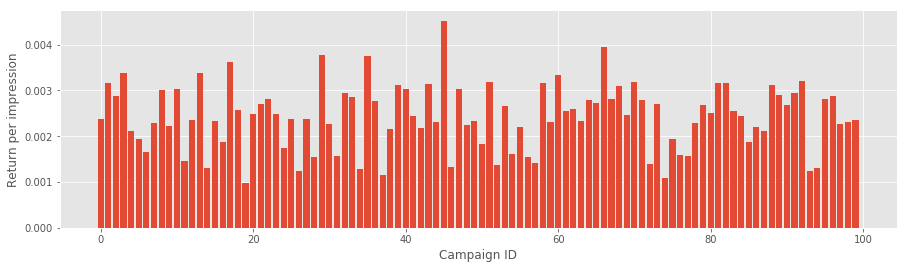

In [32]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

campaign_idx = range(150, 250)

keras_logistic = model1.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logistic = softmax([keras_logistic]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logistic[campaign_idx])), keras_logistic[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

#### Attribution Weights

In [33]:
keras_logistic

array([0.00232201, 0.00312844, 0.00147883, 0.00216226, 0.00149577,
       0.00300418, 0.00190545, 0.00242166, 0.00234553, 0.00199198,
       0.00304257, 0.00127012, 0.002335  , 0.00233377, 0.00220571,
       0.00158466, 0.00407273, 0.00156299, 0.00164922, 0.0021392 ,
       0.00383461, 0.00157069, 0.00204161, 0.0024412 , 0.00232036,
       0.00318704, 0.00299496, 0.00158254, 0.00310078, 0.00324086,
       0.00267555, 0.00246236, 0.00273928, 0.0020281 , 0.00186485,
       0.00294264, 0.00267993, 0.00217368, 0.00175291, 0.00324061,
       0.00123323, 0.00165512, 0.00385873, 0.00272411, 0.00256467,
       0.00149354, 0.0020203 , 0.00237623, 0.00237004, 0.00143968,
       0.00261711, 0.00255414, 0.00120577, 0.00233123, 0.00223594,
       0.00291015, 0.00227793, 0.00319012, 0.00250513, 0.00295825,
       0.00244498, 0.00173654, 0.00287467, 0.00196191, 0.00270316,
       0.00283313, 0.00276377, 0.00141506, 0.00198851, 0.002226  ,
       0.0022142 , 0.002957  , 0.00237284, 0.00184711, 0.00398

In [34]:
np.savetxt("logistic.txt",keras_logistic)